In [1]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import os
import cv2
import numpy as np
from PIL import Image
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import CLIPProcessor, CLIPModel
from models.clip_module import clip_prediction, load_images
from models.sam_module import segment_image
import os
import torch
import cv2
import numpy as np
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from torchvision import transforms
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator


def load_images(image_paths):
    """ Load images from given paths. """
    return [Image.open(path) for path in image_paths]

def create_and_show_grid(image_dict, max_images_per_row=5):
    padding = 10  # Space between images
    image_size = (100, 100)  # Size of each image in the grid

    # Determine the size of the grid
    total_width = max_images_per_row * (image_size[0] + padding) - padding
    total_rows = sum(-(-len(imgs) // max_images_per_row) for imgs in image_dict.values()) + len(image_dict)
    total_height = total_rows * (image_size[1] + padding) + padding

    # Create a new image with a white background
    new_im = Image.new('RGB', (total_width, total_height), 'white')
    draw = ImageDraw.Draw(new_im)

    y_offset = padding
    for label, paths in image_dict.items():
        images = load_images(paths)
        draw.text((padding, y_offset), label, fill="black", font=ImageFont.load_default())
        y_offset += 20  # Space for the label
        x_offset = padding
        row_images = 0
        for im in images:
            im = im.resize(image_size)
            new_im.paste(im, (x_offset, y_offset))
            x_offset += image_size[0] + padding
            row_images += 1
            if row_images >= max_images_per_row:
                row_images = 0
                y_offset += image_size[1] + padding
                x_offset = padding
        y_offset += image_size[1] + padding

    # Display the grid in the Jupyter Notebook
    display(new_im)




In [4]:
from pipeline import run_pipeline, get_file_paths, clear_directory

CLIP_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(CLIP_device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
label_texts =  [
    "antelope", "badger", "bat", "bear", "bee", "background", "unknown"]  # Add your text here


dir_path = "/home/jr151/code/projects/Auto-Segment-Collage/input/custom_dataset_5"
image_paths = get_file_paths(dir_path)
SAM_CHECKPOINT_PATH = '/home/jr151/model/seg/sam_vit_h_4b8939.pth'      # TODO: Replace with the path to the checkpoint file
SAM_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH).to(device=SAM_device)
mask_generator = SamAutomaticMaskGenerator(sam)
segment_result_dir = 'results'

clear_directory(segment_result_dir)

animal_images = run_pipeline(image_paths, mask_generator, clip_model, clip_processor, CLIP_device, label_texts, segment_result_dir)


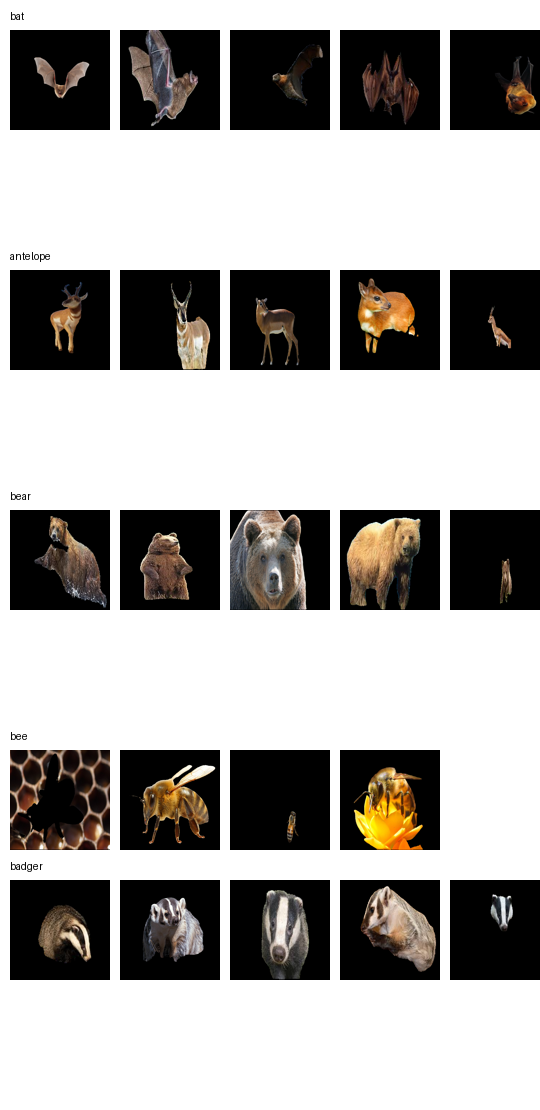

In [5]:
create_and_show_grid(animal_images)

In [3]:
from models.clip_module import clip_prediction, load_images


processed_images = load_images(animal_images['cow'])
probs, preds = clip_prediction(clip_model, clip_processor, processed_images, label_texts, CLIP_device)

# Function to get top probabilities and labels for each image
def get_top_predictions(probabilities, labels, top_n=5):
    results = []
    for index, probs in enumerate(probabilities):
        top_indices = np.argsort(probs)[-top_n:][::-1]  # Get indices of the top 'n' probabilities, reversed for descending order
        top_probs = probs[top_indices]  # Extract the top probabilities using the indices
        top_labels = [labels[i] for i in top_indices]  # Map indices to labels

        image_result = {
            'image_index': index,
            'top_probabilities': top_probs.tolist(),
            'top_labels': top_labels
        }
        results.append(image_result)
        
        # Optionally, print the results for each image
        print(f"Image {index+1}:")
        for prob, label in zip(top_probs, top_labels):
            print(f"  Label: {label}, Probability: {prob:.6f}")
        print()  # New line for better separation between image results

    return results

# Call the function to process the example data
top_results = get_top_predictions(probs, label_texts, top_n=5)
animal_images['deer']

Image 1:
  Label: cow, Probability: 0.468750
  Label: deer, Probability: 0.239380
  Label: antelope, Probability: 0.130127
  Label: bison, Probability: 0.078979
  Label: boar, Probability: 0.055115

Image 2:
  Label: cow, Probability: 0.239258
  Label: boar, Probability: 0.145142
  Label: deer, Probability: 0.089417
  Label: bison, Probability: 0.082703
  Label: dog, Probability: 0.078918

Image 3:
  Label: cow, Probability: 0.337158
  Label: antelope, Probability: 0.177734
  Label: boar, Probability: 0.161743
  Label: deer, Probability: 0.120239
  Label: bison, Probability: 0.075256

Image 4:
  Label: cow, Probability: 0.195557
  Label: dog, Probability: 0.126221
  Label: background, Probability: 0.126221
  Label: cat, Probability: 0.069702
  Label: bee, Probability: 0.058716

Image 5:
  Label: cow, Probability: 0.197021
  Label: background, Probability: 0.131226
  Label: bee, Probability: 0.110474
  Label: bat, Probability: 0.074768
  Label: chimpanzee, Probability: 0.071350

Image 6

['results/fd085737a4.jpg/segmented_image_0.png',
 'results/fd085737a4.jpg/segmented_image_1.png',
 'results/8b1539144f.jpg/segmented_image_6.png',
 'results/6fb2619e84.jpg/segmented_image_2.png']

In [25]:
import numpy as np
from torch.cuda.amp import autocast
from  PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel


def clip_prediction(model, processor, images, texts, device):
    """
    Make predictions on the images and texts

    Args:
    model: CLIP model
    processor: CLIP processor
    images: List of PIL images
    texts: List of texts
    device: Device to run the model on

    Returns:
    max_probs: Max predicted probabilities for each label
    best_pred: Best predicted label and its corresponding image
    """

    # Process the inputs
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the correct device

    # Make predictions
    with autocast(enabled=True):
        outputs = model(**inputs)

    # Calculate probabilities
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
   
    probs = logits_per_image.softmax(dim=1)  # we apply softmax to get probabilities
    probs = probs.cpu().detach().numpy()  # move data back to cpu and convert to numpy
    print(probs)
    # Get the max probability and its index for each label
    max_probs_indices = np.argmax(probs, axis=0)
    print(max_probs_indices)
    max_probs = np.max(probs, axis=0)
    print(max_probs)

    # Get the best prediction (label with the highest probability)
    best_pred_index = np.argmax(max_probs)
    best_pred = texts[best_pred_index]
    # best_segment_path = image_paths[best_pred_index]

    return logits_per_image, max_probs, (best_pred_index, best_pred)

def clip_prediction(model, processor, images, texts, device):
    """
    Make predictions on the images and texts

    Args:
    model: CLIP model
    processor: CLIP processor
    images: List of PIL images
    texts: List of texts
    device: Device to run the model on

    Returns:
    max_prob: Maximum predicted probability
    best_segment: Best segmented image
    best_label: Best label associated with the best_segment
    """

    # Process the inputs
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the correct device

    # Make predictions
    with torch.cuda.amp.autocast(enabled=True):
        outputs = model(**inputs)

    # Calculate probabilities
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we apply softmax to get probabilities
    probs = probs.cpu().detach().numpy()  # move data back to cpu and convert to numpy

    # Find the index of the highest probability in the entire matrix
    max_prob_index = np.argmax(probs)  # Index in flattened array
    print(max_prob_index)
    max_prob_indices = np.unravel_index(max_prob_index, probs.shape)  # Convert to tuple (row, col)
    print(max_prob_indices)
    max_prob = probs[max_prob_indices[0], max_prob_indices[1]]
    best_segment = images[max_prob_indices[0]]
    best_label = texts[max_prob_indices[1]]

    return max_prob, best_segment, best_label

def clip_prediction(model, processor, images, texts, device):
    """
    Make predictions on the images and texts and return the top 3 probabilities with their corresponding images and labels.

    Args:
    model: CLIP model
    processor: CLIP processor
    images: List of PIL images
    texts: List of texts
    device: Device to run the model on

    Returns:
    top_probs: List of top 3 probabilities
    top_segments: List of images corresponding to the top 3 probabilities
    top_labels: List of labels corresponding to the top 3 probabilities
    """

    # Process the inputs
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the correct device

    # Make predictions
    with torch.cuda.amp.autocast(enabled=True):
        outputs = model(**inputs)

    # Calculate probabilities
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we apply softmax to get probabilities
    probs = probs.cpu().detach().numpy()  # move data back to cpu and convert to numpy

    # Flatten the probability matrix to sort and find top 3 probabilities
    flat_indices = np.argsort(-probs.ravel())[:3]  # Get indices of top 3 probabilities in flattened array
    top_probs_indices = np.unravel_index(flat_indices, probs.shape)  # Convert flat indices to tuple (row, col)
    print(top_probs_indices)
    # Extract top 3 probabilities, segments, and labels
    top_probs = probs[top_probs_indices]
    top_segments = [images[idx] for idx in top_probs_indices[0]]
    top_labels = [texts[idx] for idx in top_probs_indices[1]]

    return top_probs, top_segments, top_labels

image_paths = get_file_paths("/home/jr151/code/projects/Auto-Segment-Collage/results/8b1539144f.jpg")

processed_images = load_images(image_paths)
top_probs, top_segments, top_labels =clip_prediction(clip_model, clip_processor, processed_images, label_texts, CLIP_device)
top_probs, top_labels
# print(logits_per_image)

(array([17, 11,  5]), array([ 0, 10, 13]))


(array([0.8555, 0.6147, 0.4688], dtype=float16),
 ['antelope', 'caterpillar', 'cow'])

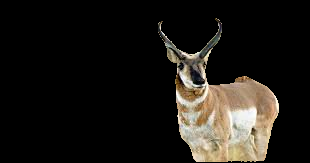

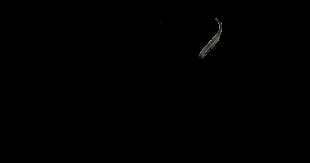

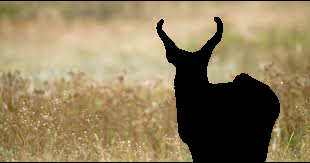

In [23]:
from PIL import Image
from IPython.display import display

for img in top_segments:
    display(img)